In [74]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import os
os.listdir('./dataset')

['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

In [57]:
# df_cus = pd.read_csv(r'./dataset/olist_customers_dataset.csv')
# df_geo = pd.read_csv(r'./dataset/olist_geolocation_dataset.csv')
# df_orders = pd.read_csv(r'./dataset/olist_orders_dataset.csv')
# df_order_items = pd.read_csv(r'./dataset/olist_order_items_dataset.csv')
# df_order_pmt = pd.read_csv(r'./dataset/olist_order_payments_dataset.csv')
# df_order_review = pd.read_csv(r'./dataset/olist_order_reviews_dataset.csv')
# df_prod = pd.read_csv(r'./dataset/olist_products_dataset.csv')
# df_sellers = pd.read_csv(r'./dataset/olist_sellers_dataset.csv')
# df_product_cat = pd.read_csv(r'./dataset/product_category_name_translation.csv')

In [44]:
customers_df = pd.read_csv('./dataset/olist_customers_dataset.csv')
order_items_df = pd.read_csv('./dataset/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('./dataset/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('./dataset/olist_orders_dataset.csv')
products_df = pd.read_csv('./dataset/olist_products_dataset.csv')
sellers_df = pd.read_csv('./dataset/olist_sellers_dataset.csv')
category_translation_df = pd.read_csv('./dataset/product_category_name_translation.csv')
geo_df = pd.read_csv(r'./dataset/olist_geolocation_dataset.csv')

datasets = {
    'Customers': customers_df,
    'Order Items': order_items_df,
    'Order Payments': order_payments_df,
    'Order Reviews': order_reviews_df,
    'Orders': orders_df,
    'Products': products_df,
    'Sellers': sellers_df,
    'Category Translation': category_translation_df,
    "Geo": geo_df
}

## PART1 - EDA

In [138]:
datasets['Order Items'].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [38]:
datasets['Customers']['customer_state'].value_counts(normalize=True).head(10)

customer_state
SP    0.419807
RJ    0.129242
MG    0.117004
RS    0.054967
PR    0.050734
SC    0.036574
BA    0.033990
DF    0.021520
ES    0.020444
GO    0.020314
Name: proportion, dtype: float64

In [43]:
print("Number of customer_id ", len(pd.unique(datasets['Customers']['customer_id'])))
print("Number of customer_unique_id", len(pd.unique(datasets['Customers']['customer_unique_id'])))

Number of customer_id  99441
Number of customer_unique_id 96096


In [127]:
df_order = datasets['Orders'].merge(datasets['Order Items'].groupby(['order_id']).agg(cnt_item=('product_id','count'),
                                                                                      price=('price','sum'),
                                                                                      freight_value=('freight_value','sum'),
                                                                                      seller_id=('seller_id', 'max')).reset_index(), 
                                    how='left', on=['order_id'])\
                             .merge(datasets['Customers'][['customer_id','customer_city','customer_state']], how='left', on=['customer_id'])\
                             .merge(datasets['Sellers'], how='left', on=['seller_id'])

df_order['delivery_time'] = (pd.to_datetime(df_order['order_delivered_customer_date']) - pd.to_datetime(df_order['order_purchase_timestamp'])).dt.days
df_order['flag_late'] = np.where(pd.to_datetime(df_order['order_delivered_customer_date'])>pd.to_datetime(df_order['order_estimated_delivery_date']), 1, 0)

In [94]:
df_order['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [96]:
df_order[df_order['order_status']=='delivered']['flag_late'].value_counts(normalize=True)

flag_late
0    0.918883
1    0.081117
Name: proportion, dtype: float64

In [97]:
df_order.loc[df_order['order_status']=='delivered', ['price','freight_value','delivery_time']].describe()

,price,freight_value,delivery_time
count,96478.000000,96478.000000,96470.000000
mean,137.041586,22.785253,12.093604
std,209.045198,21.559197,9.551380
min,0.850000,0.000000,0.000000
25%,45.900000,13.850000,6.000000
50%,86.575000,17.170000,10.000000
75%,149.900000,24.017500,15.000000
max,13440.000000,1794.960000,209.000000


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24072\2995451503.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_state_agg['customer_state'], rotation=0)


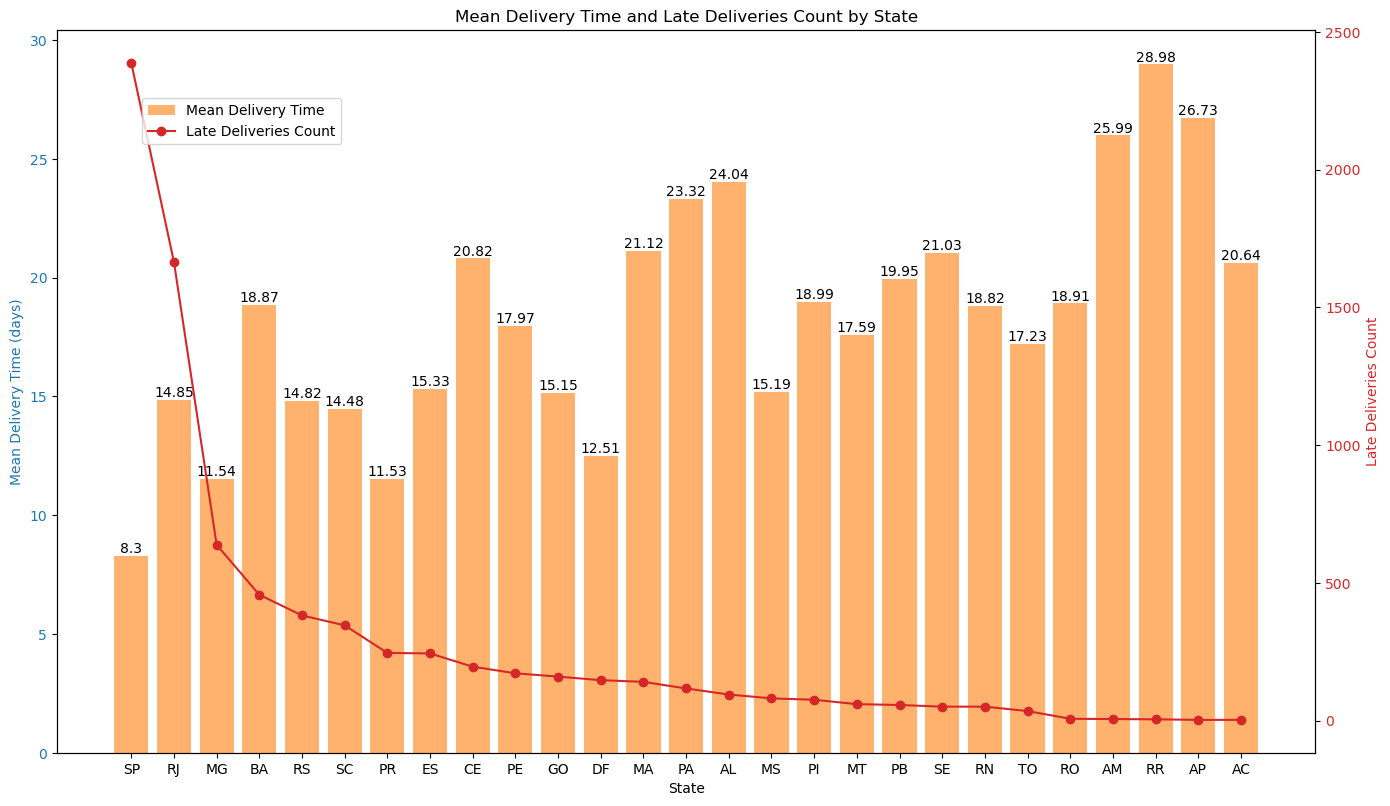

In [114]:
df_state_agg = df_order.groupby(['customer_state']).agg(avg_delivery=('delivery_time','mean'),
                                         flag_late=('flag_late','sum')).sort_values(by=['flag_late'], ascending=False).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the bar chart
ax1.set_xlabel('State')
ax1.set_ylabel('Mean Delivery Time (days)', color='tab:blue')
bars = ax1.bar(df_state_agg['customer_state'], df_state_agg['avg_delivery'], color='tab:orange', alpha=0.6, label='Mean Delivery Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', ha='center', color='black', fontsize=10)

ax2 = ax1.twinx()
ax2.set_ylabel('Late Deliveries Count', color='tab:red')
line = ax2.plot(df_state_agg['customer_state'], df_state_agg['flag_late'], color='tab:red', marker='o', label='Late Deliveries Count')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_xticklabels(df_state_agg['customer_state'], rotation=0)
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('Mean Delivery Time and Late Deliveries Count by State')
plt.show()

In [135]:
df_order.groupby(['seller_state']).agg(cnt_seller=('seller_id','nunique'),
                                       cnt_order=('order_id','nunique'),
                                        cnt_late=('flag_late','sum')).sort_values(by=['cnt_order'], ascending=False).reset_index().head(10)

,seller_state,cnt_seller,cnt_order,cnt_late
0,SP,1845,69975,6001
1,MG,242,7824,431
2,PR,348,7583,485
3,RJ,171,4313,355
4,SC,190,3630,215
5,RS,128,1975,84
6,DF,30,821,48
7,BA,19,566,32
8,GO,40,463,18
9,PE,9,406,18


In [155]:
df_products = datasets['Order Items'].merge(datasets['Products'], how='left', on=['product_id'])\
                                    .merge(df_order[['order_id','flag_late','delivery_time']], how='left', on=['order_id'])\
                                    .merge(datasets['Category Translation'], how='left', on=['product_category_name'])
df_products.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,flag_late,delivery_time,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,0,7.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,0,16.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,0,7.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,0,6.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,0,25.0,garden_tools


In [193]:
df_products_top10 = df_products.groupby(['product_category_name_english']).agg(sum_price=('price', 'sum'),
                                                   sum_freight_value=('freight_value', 'sum'),
                                                   avg_price=('price', 'mean'),
                                                   avg_freight_value=('freight_value', 'mean'),
                                                   sum_late=('flag_late', 'sum'),
                                                   mean_delivery_time=('delivery_time', 'mean'),
                                                   num_order=('order_id','nunique')).sort_values(by=['sum_price','num_order'], ascending=False).head(10).reset_index()
df_products_top10

,product_category_name_english,sum_price,sum_freight_value,avg_price,avg_freight_value,sum_late,mean_delivery_time,num_order
0,health_beauty,1258681.34,182566.73,130.163531,18.879703,858,11.516954,8836
1,watches_gifts,1205005.68,100535.93,201.135984,16.781160,485,12.191736,5624
2,bed_bath_table,1036988.68,204693.04,93.296327,18.415928,920,12.336803,9417
3,sports_leisure,988048.97,168607.51,114.344285,19.512500,625,11.692563,7720
4,computers_accessories,911954.32,147318.08,116.513903,18.821781,594,12.779799,6689
5,furniture_decor,729762.49,172749.30,87.564494,20.728258,688,12.404044,6449
6,cool_stuff,635290.85,84039.10,167.357969,22.138857,251,11.898601,3632
7,housewares,632248.66,146149.11,90.788148,20.986374,441,10.456512,5884
8,auto,592720.11,92664.21,139.957523,21.880569,343,11.766369,3897
9,garden_tools,485256.46,98962.75,111.630196,22.765758,340,13.231959,3518


In [185]:
df_pmt = datasets['Order Payments'].groupby(['payment_type']).agg(num_install=('payment_installments','sum'),
                                                         num_seq=('payment_sequential','sum'),
                                                         sum_payment_value=('payment_value','sum')).sort_values(by=['sum_payment_value'], ascending=False)
df_pmt['avg_per_seq'] = round(df_pmt['sum_payment_value']/df_pmt['num_seq'],2)

In [186]:
df_pmt

,num_install,num_seq,sum_payment_value,avg_per_seq
payment_type,,,,
credit_card,269332,77115,12542084.19,162.64
boleto,19784,19785,2869361.27,145.03
voucher,5775,15029,379436.87,25.25
debit_card,1529,1582,217989.79,137.79
not_defined,3,3,0.00,0.00


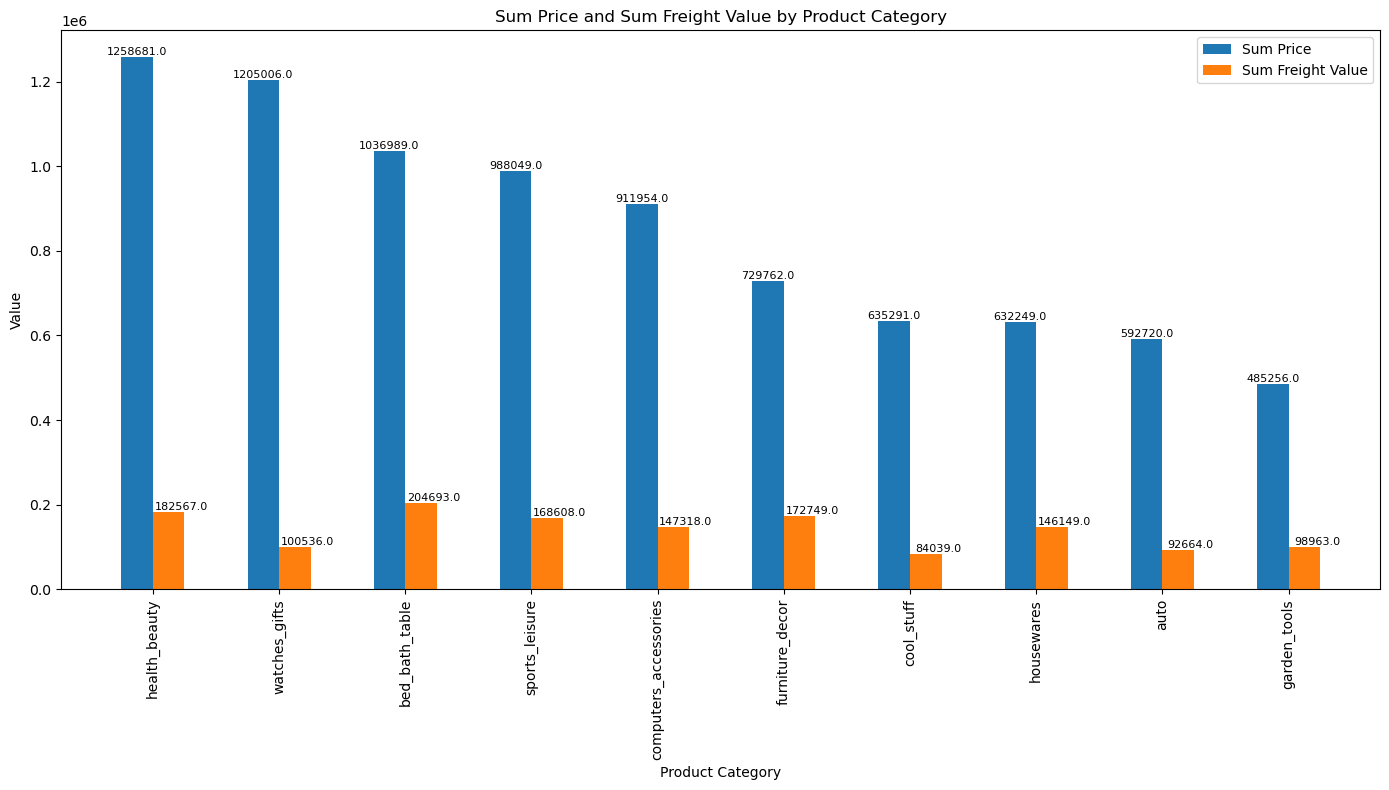

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24072\3695269533.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['product_category_name_english'], rotation=90)


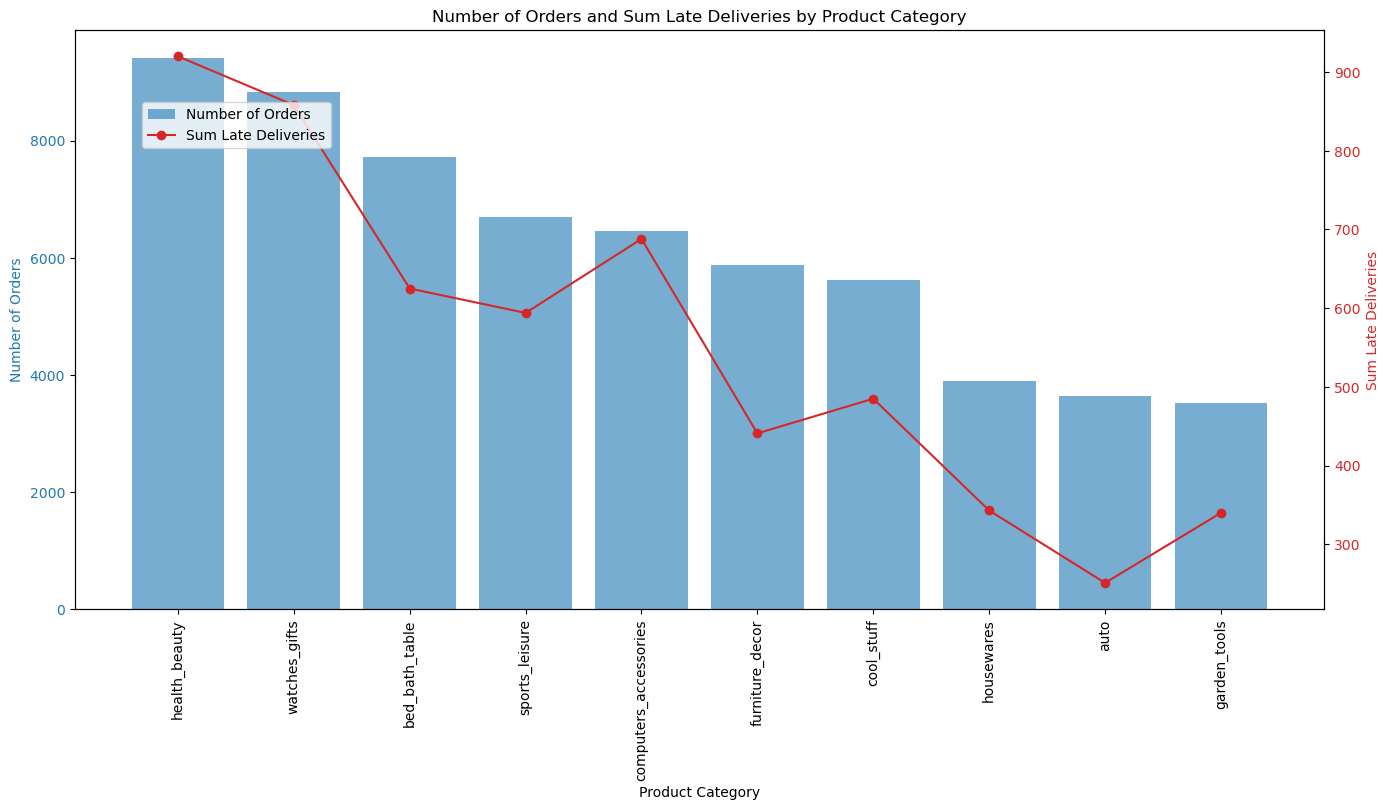

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24072\3695269533.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_products_top10_tmp3['product_category_name_english'], rotation=90)


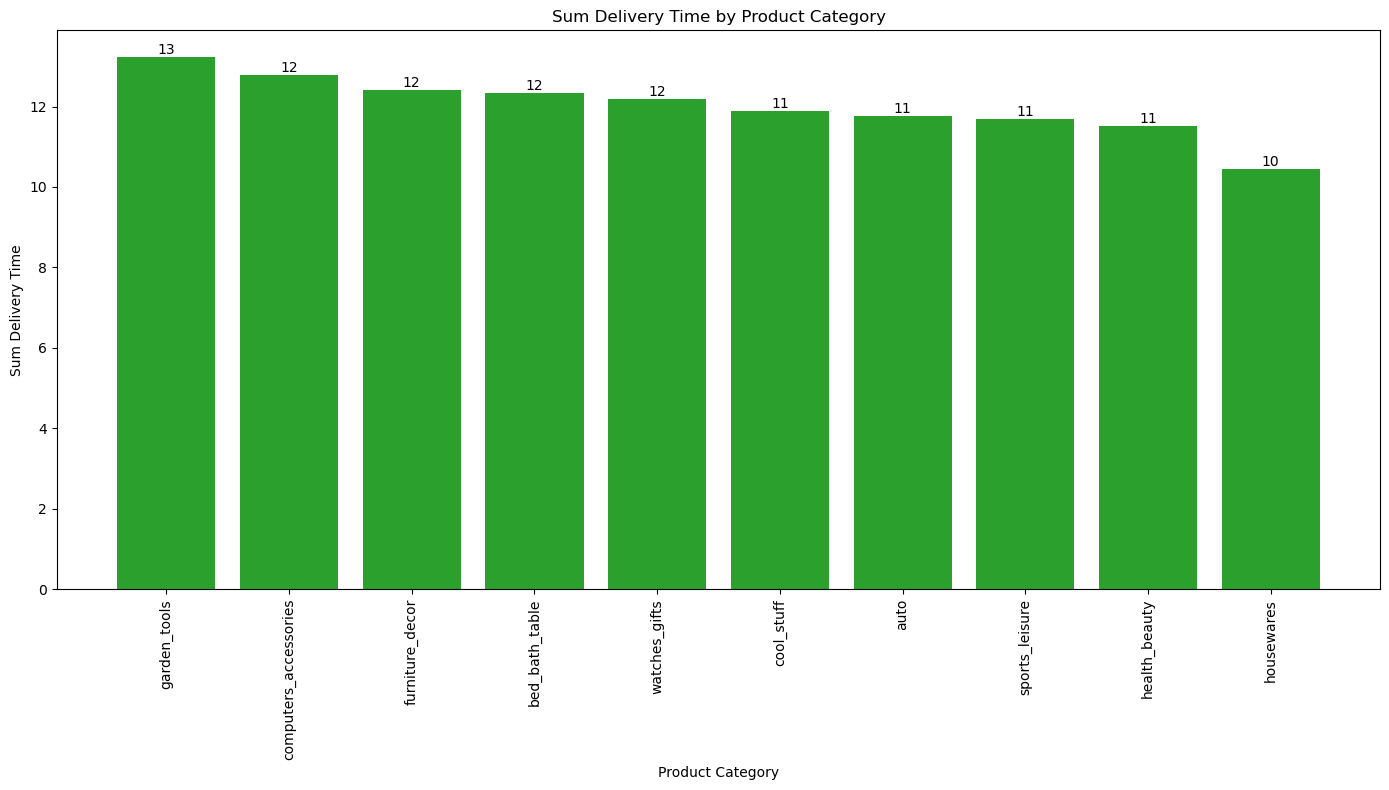

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the dataframe
data = {
    'product_category_name_english': ['health_beauty', 'watches_gifts', 'bed_bath_table', 'sports_leisure', 
                                      'computers_accessories', 'furniture_decor', 'cool_stuff', 'housewares', 
                                      'auto', 'garden_tools'],
    'sum_price': [1258681.34, 1205005.68, 1036988.68, 988048.97, 911954.32, 729762.49, 635290.85, 632248.66, 592720.11, 485256.46],
    'sum_freight_value': [182566.73, 100535.93, 204693.04, 168607.51, 147318.08, 172749.30, 84039.10, 146149.11, 92664.21, 98962.75],
    'avg_price': [130.163531, 201.135984, 93.296327, 114.344285, 116.513903, 87.564494, 167.357969, 90.788148, 139.957523, 111.630196],
    'avg_freight_value': [18.879703, 16.781160, 18.415928, 19.512500, 18.821781, 20.728258, 22.138857, 20.986374, 21.880569, 22.765758],
    'sum_late': [858, 485, 920, 625, 594, 688, 251, 441, 343, 340],
    'sum_delivery_time': [109031.0, 71407.0, 135125.0, 98580.0, 97676.0, 101217.0, 44239.0, 71052.0, 48701.0, 56474.0],
    'num_order': [8836, 5624, 9417, 7720, 6689, 6449, 3632, 5884, 3897, 3518]
}

df = df_products_top10.copy()

# Plot 1: Group Bar Chart with numbers on the bar
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(df['product_category_name_english']))

bars1 = ax.bar(index, df['sum_price'], bar_width, label='Sum Price', color='tab:blue')
bars2 = ax.bar(index + bar_width, df['sum_freight_value'], bar_width, label='Sum Freight Value', color='tab:orange')

ax.set_xlabel('Product Category')
ax.set_ylabel('Value')
ax.set_title('Sum Price and Sum Freight Value by Product Category')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df['product_category_name_english'], rotation=90)
ax.legend()

# Add numbers on bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 0), va='bottom', ha='center', color='black', fontsize=8)
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + 0.1 + bar.get_width() / 2.0, yval, round(yval, 0), va='bottom', ha='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()

# Plot 2: Bar chart + Line chart
fig, ax1 = plt.subplots(figsize=(14, 8))
df_products_top10_tmp2 = df_products_top10.sort_values(by=['num_order'], ascending=False)
ax1.set_xlabel('Product Category')
ax1.set_ylabel('Number of Orders', color='tab:blue')
bars = ax1.bar(df_products_top10_tmp2['product_category_name_english'], df_products_top10_tmp2['num_order'], 
               color='tab:blue', alpha=0.6, label='Number of Orders')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for the line chart
ax2 = ax1.twinx()
ax2.set_ylabel('Sum Late Deliveries', color='tab:red')
line = ax2.plot(df_products_top10_tmp2['product_category_name_english'], df_products_top10_tmp2['sum_late'], color='tab:red', marker='o', label='Sum Late Deliveries')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add labels and title
ax1.set_xticklabels(df['product_category_name_english'], rotation=90)
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('Number of Orders and Sum Late Deliveries by Product Category')
plt.show()

# Plot 3: Bar chart for sum_delivery_time
fig, ax = plt.subplots(figsize=(14, 8))
df_products_top10_tmp3 = df_products_top10.sort_values(by=['mean_delivery_time'], ascending=False)
bars = ax.bar(df_products_top10_tmp3['product_category_name_english'], df_products_top10_tmp3['mean_delivery_time'], color='tab:green')

ax.set_xlabel('Product Category')
ax.set_ylabel('Sum Delivery Time')
ax.set_title('Sum Delivery Time by Product Category')
ax.set_xticklabels(df_products_top10_tmp3['product_category_name_english'], rotation=90)

# Add numbers on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, yval, int(yval), va='bottom', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()


In [20]:
# # 1. Order Status Distribution
# plt.figure(figsize=(10, 6))
# df_orders['order_status'].value_counts().plot(kind='bar', color='skyblue')
# plt.title('Distribution of Order Status')
# plt.xlabel('Order Status')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.show()

# # 2. Sales Over Time
# df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
# monthly_orders = df_orders.set_index('order_purchase_timestamp').resample('M').size()
# plt.figure(figsize=(12, 6))
# monthly_orders.plot()
# plt.title('Monthly Orders Over Time')
# plt.xlabel('Month')
# plt.ylabel('Number of Orders')
# plt.show()

# # 3. Geographical Distribution of Customers
# plt.figure(figsize=(10, 6))
# df_cus['customer_city'].value_counts().head(10).plot(kind='bar', color='green')
# plt.title('Top 10 Cities by Number of Customers')
# plt.xlabel('City')
# plt.ylabel('Number of Customers')
# plt.xticks(rotation=45)
# plt.show()

# # 4. Product Category Distribution
# df_product_cat['product_category_name'].value_counts().head(10).plot(kind='bar', color='purple')
# plt.title('Top 10 Product Categories')
# plt.xlabel('Category')
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.show()